In [1]:
from config import * # Import all configurations
%matplotlib inline

✅ 字体加载成功: Microsoft YaHei


In [4]:
import pandas as pd
sql_query = """
SELECT
    oord.review_score, 
    -- 实际总物流耗时均值
    AVG(JULIANDAY(ood.order_delivered_customer_date) - JULIANDAY(ood.order_purchase_timestamp)) AS AVG_delivery_days,
    -- 延迟天数均值
    AVG(JULIANDAY(ood.order_delivered_customer_date) - JULIANDAY(ood.order_estimated_delivery_date)) AS AVG_delay_days
FROM olist_orders_dataset ood
JOIN olist_order_reviews_dataset oord ON ood.order_id = oord.order_id 
WHERE ood.order_status = 'delivered'
  AND ood.order_delivered_customer_date IS NOT NULL 
  AND ood.order_estimated_delivery_date IS NOT NULL
GROUP BY 1 
ORDER BY oord.review_score DESC; -- 改为按评分排序，观察延迟的变化趋势
"""
df_logistic=pd.read_sql(sql_query,conn)
df_logistic.head()

,review_score,AVG_delivery_days,AVG_delay_days
0,5,10.688660,-12.687807
1,4,12.312356,-11.684076
2,3,14.259974,-10.081382
3,2,16.660580,-7.938027
4,1,21.311499,-3.358079


✅ 字体加载成功: Microsoft YaHei
📊 分析结论:
1. 5分订单平均耗时 10.7 天，而1分订单耗时达 21.3 天。
2. 物流时长翻倍是导致差评的核心诱因。


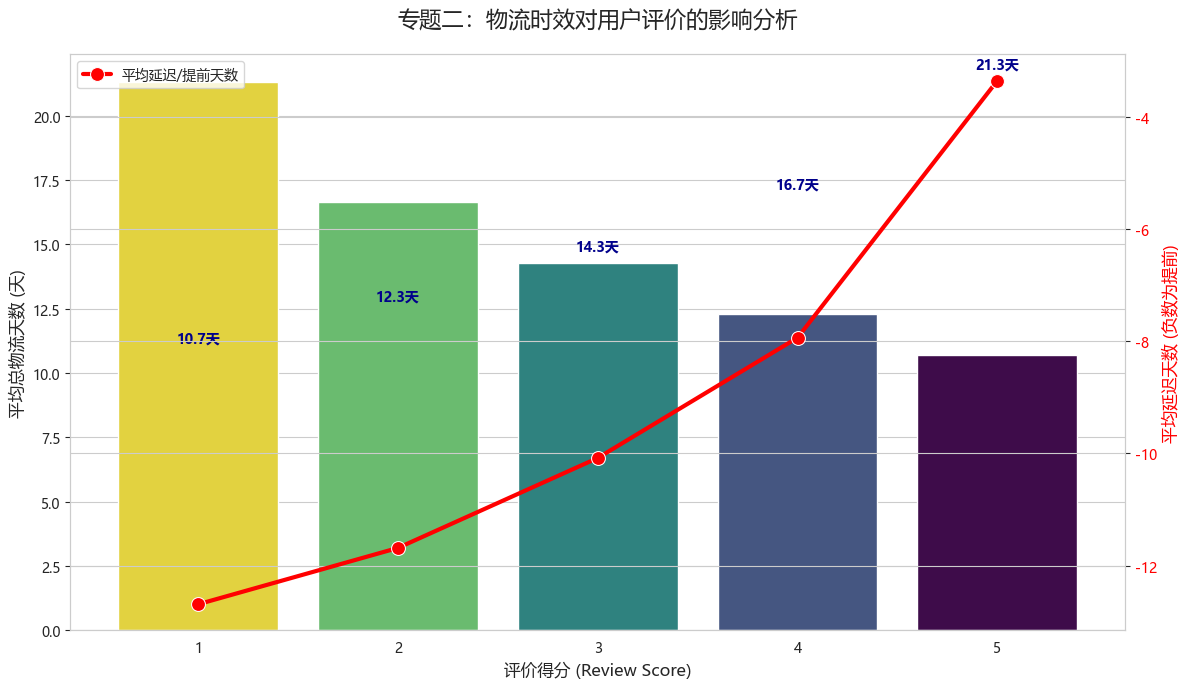

In [1]:
from config import *
# 2. SQL 数据提取 (物流耗时与评分关联)
query = """
SELECT
    oord.review_score, 
    AVG(JULIANDAY(ood.order_delivered_customer_date) - JULIANDAY(ood.order_purchase_timestamp)) AS AVG_delivery_days,
    AVG(JULIANDAY(ood.order_delivered_customer_date) - JULIANDAY(ood.order_estimated_delivery_date)) AS AVG_delay_days
FROM olist_orders_dataset ood
JOIN olist_order_reviews_dataset oord ON ood.order_id = oord.order_id 
WHERE ood.order_status = 'delivered'
  AND ood.order_delivered_customer_date IS NOT NULL 
GROUP BY 1 
ORDER BY 1 DESC;
"""

# 将结果读入 DataFrame
df_logistic = pd.read_sql(query, conn)

# ==========================================
# 3. 自动化可视化绘图
# ==========================================
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid", {"font.sans-serif": [prop.get_name()]})

# --- 绘制主轴：实际总物流耗时 (柱状图) ---
ax1 = sns.barplot(
    x='review_score', 
    y='AVG_delivery_days', 
    data=df_logistic,
    palette='viridis_r',
    hue='review_score',  # 明确指定按评分着色
    legend=False           # 隐藏侧边多余的图例
)
ax1.set_title('专题二：物流时效对用户评价的影响分析', fontsize=16, pad=20)
ax1.set_xlabel('评价得分 (Review Score)', fontsize=12)
ax1.set_ylabel('平均总物流天数 (天)', fontsize=12)

# --- 绘制副轴：平均延迟天数 (折线图) ---
ax2 = ax1.twinx()
sns.lineplot(
    x=range(len(df_logistic)), 
    y=df_logistic['AVG_delay_days'], 
    marker='o', 
    markersize=10,
    color='red', 
    ax=ax2, 
    linewidth=3, 
    label='平均延迟/提前天数'
)
ax2.set_ylabel('平均延迟天数 (负数为提前)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# --- 添加数值标注 (让图表更职业) ---
for i, v in enumerate(df_logistic['AVG_delivery_days']):
    ax1.text(i, v + 0.5, f'{v:.1f}天', ha='center', fontweight='bold', color='darkblue')

# 显示图例并打印结论
print("📊 分析结论:")
print(f"1. 5分订单平均耗时 {df_logistic.iloc[0,1]:.1f} 天，而1分订单耗时达 {df_logistic.iloc[-1,1]:.1f} 天。")
print("2. 物流时长翻倍是导致差评的核心诱因。")

plt.tight_layout()
plt.show()